In [19]:
#in this notebook we're going to write all of the data processing steps of our pipeline
#Inputs - Alignments with associated PDB files

#Outputs - X: fourier transfor of 3d matrix of prot features. possible distmat of potts model
#Y: distmat of 3d fold (biopython), protein class(from SCOP or CATH) ,torsion angles, ss , solvent access ( DSSP )

#### Imports

In [20]:
import os
import glob
import wget
import time
import subprocess
import shlex
import sys
import warnings
import random

from Bio.SeqUtils import seq1
from Bio.PDB.PDBParser import PDBParser
from Bio import AlignIO

from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler,  Normalizer , MinMaxScaler , RobustScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

'''
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ResourceProfiler, Profiler, ProgressBar

from daskml.preprocessing import RobustScaler
from daskml.decomposition import IncrementalPCA

from sklearn.pipeline import make_pipeline'''

sys.path.append('./ProFET/ProFET/feat_extract/')
import FeatureGen

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import h5py

#### Class definitions

In [21]:
#PCA and scaler
class NDSRobust(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = RobustScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self
    
    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def inverse_transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.inverse_transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X
    
    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

#ndimensional PCA for arrays

class NDSPCA(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = IncrementalPCA(copy = True, **kwargs)
        self._orig_shape = None
    
    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        self.explained_variance_ratio_ = self._scaler.explained_variance_ratio_
        self.components_ =self._scaler.components_
        
        return self
    
    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        
        return X
    
    def inverse_transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.inverse_transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X
    
    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

#### Function definitions
##### PCA and scaler

In [22]:
#fit the components of the output space
#stacked distmats (on the 1st axis)
def fit_y( y, components = 300,  batch_size = 10, FFT = True ):
    if FFT == True:
        #got through a stack of structural distmats. these should be 0 padded to all fit in an array
        
        y = np.stack([ np.fft.rfft2(y[i,:,:]) for i in range(y.shape[0])] )
        print(y.shape)
        y =  np.hstack( [ np.real(y) , np.imag(y)]  )
    print(y.shape)
    ndpca = NDSPCA(n_components=components)
    
    #https://stackoverflow.com/questions/44334950/how-to-use-sklearns-incrementalpca-partial-fit
    
    nb_rows = y.shape[0]
    #check if // doesn't cause loss of data
    for i in range(0, nb_rows//batch_size):
        ndpca.partial_fit(y[i*batch_size : (i+1)*batch_size, :, :])
    
    print('explained variance')
    print(np.sum(ndpca.explained_variance_ratio_))
       
    #ndpca.fit(y)
    #print('explained variance')
    #print(np.sum(ndpca.explained_variance_ratio_))
    #y = ndpca.transform(y)
    #replace with https://ml.dask.org/modules/generated/dask_ml.preprocessing.RobustScaler.html#dask_ml.preprocessing.RobustScaler
    scaler0 = RobustScaler()
    scaler0.fit(y)
    return scaler0, ndpca, out

def transform_y(y, scaler0, ndpca,  batch_size = 10, FFT = False):
    if FFT == True:
        y = np.stack([np.fft.rfft2(y[i,:,:]) for i in range(y.shape[0])])
        print(y.shape)
        y =  np.hstack( [ np.real(y) , np.imag(y)]  )
        
    nb_rows = y.shape[0]
    out = np.zeros((components, y.shape[1], y.shape[2])) #array to contain components
    for i in range(0, nb_rows//batch_size):
        out[i*chunk_size : (i+1)*batch_size,:,:] = ndpca.transform(y[i*batch_size : (i+1)*batch_size,:,:])    
    
    #y = ndpca.transform(y)
    #print(y.shape)
    #y = scaler0.transform(y)
    
    out = scaler0.transform(out)
    
    return '''y''' out

def inverse_transform_y(y, scaler0, ndpca, FFT=False):
    y = scaler0.inverse_transform(y)
    y = ndpca.inverse_transform(y)
    
    if FFT == True:
        split = int(y.shape[1]/2)
        y = np.stack([ np.fft.irfft2(y[i,:split,:] + 1j*y[i,split:,:]) for i in range(y.shape[0]) ] )
        
    return y

#fit the components of the in space
#stacked align voxels (on the 1st axis)
def fit_x(x, components = 300,  batch_size = 10, FFT = True):
    if FFT == True:
        #got through a stack of align voxels. these should be 0 padded to all fit in an array
        
        x = np.stack([ np.fft.rfftn(x[i,:,:,:]) for i in range(x.shape[0])] )
        print(x.shape)
        x =  np.hstack( [ np.real(x) , np.imag(x)]  )
    print(x.shape)
    ndpca = NDSPCA(n_components=components)
    
    nb_rows = x.shape[0]
    #check if // doesn't cause loss of data
    for i in range(0, nb_rows//batch_size):
        ndpca.partial_fit(x[i*batch_size : (i+1)*batch_size,:,:,:])
    
    print('explained variance')
    print(np.sum(ndpca.explained_variance_ratio_))
    
    #ndpca.fit(x)
    #print('explained variance')
    #print(np.sum(ndpca.explained_variance_ratio_))
    #x = ndpca.transform(x)
    #replace with https://ml.dask.org/modules/generated/dask_ml.preprocessing.RobustScaler.html#dask_ml.preprocessing.RobustScaler
    scaler0 = RobustScaler()
    scaler0.fit(x)
    return scaler0, ndpca, out

def transform_x(x, scaler0, ndpca, batch_size = 10, FFT = False):
    if FFT == True:
        x = np.stack([ np.fft.rfftn(x[i,:,:,:]) for i in range(x.shape[0])] )
        print(x.shape)
        x =  np.hstack( [ np.real(x) , np.imag(x)]  )
    
    out = np.zeros((components, x.shape[1], x.shape[2], x.shape[3])) #array to contain components
    nb_rows = x.shape[0]
    for i in range(0, nb_rows//batch_size):
        out[i*batch_size : (i+1)*batch_size,:,:,:] = ndpca.transform(x[i*batch_size : (i+1)*batch_size,:,:,:])
        
    out = scaler0.transform(out)
    
    #x = ndpca.transform(x)
    #print(x.shape)
    #x = scaler0.transform(x)
    
    return '''x''' out

#todo -- check the split is happening in the right dimension
def inverse_transform_x(x, scaler0, ndpca, FFT=False):
    x = scaler0.inverse_transform(x)
    x = ndpca.inverse_transform(x)
    
    if FFT == True:
        split = int(x.shape[1]/2)
        x = np.stack([ np.fft.irfftn(x[i,:split,:,:] + 1j*x[i,split:,:,:]) for i in range(x.shape[0]) ] )
        
    return x

SyntaxError: invalid syntax (<ipython-input-22-278ce195d424>, line 49)

##### Alignments

In [23]:
#get align files
def runclustalo( infile , runIdentifier, path = 'clustalo' , outdir='./', args = '' , verbose = False):
    if verbose == True:
        print( infile , runIdentifier , path , outdir )
    #i usually use filenames that reflect what the pipeline has done until that step
    outfile= outdir+runIdentifier+infile+".aln.fasta"
    
    #here we write the command as a string using all the args
    args = path + ' -i '+  infile  +' -o '+ outfile + ' ' +args
    args = shlex.split(args)
    if verbose == True:
        print(args)
    p = subprocess.Popen(args )
    #return the opened process and the file it's creating
    
    #we can also use the communicate function later to grad stdout if we need to
    return p , outfile

#TODO - add sequence to align

def alnFileToArray(filename, returnMsa = False):
    alnfile = filename
    msa = AlignIO.read(alnfile , format = 'fasta')
    align_array = np.array([ list(rec.upper())  for rec in msa], np.character)
    
    if returnMsa:
        return align_array, msa
        
    return align_array

def alnArrayLineToSequence(align_array, index):
    seq = ''
    for aa in align_array[index]:
        seq += aa.decode('utf-8')
    
    return seq

#generate align list
def generateAlignList(directory = 'alns', returnMsa = False):
    aligns = list()
    msas = list()
    
    #read through align files to get align arrays list
    for file in os.listdir(directory):
        if file.endswith('.fasta'):
            aligns.append(alnFileToArray(directory+'/'+file, returnMsa)[0])
            if returnMsa:
                msas.append(alnFileToArray(directory+'/'+file, returnMsa)[1])
    
    if returnMsa:
        return aligns, msas
    
    return aligns

#find biggest align shape (for padding) - aligns is a list of arrays
def biggestAlignShape(aligns):
    longestProts = 0
    mostProts = 0

    for aln in aligns:
        if aln.shape[0] > mostProts:
            mostProts = aln.shape[0]
        if aln.shape[1] > longestProts:
            longestProts = aln.shape[1]
    
    return mostProts, longestProts

##### DSSP

In [24]:
def rundssp( infile , runIdentifier, path = 'dssp' , outdir='./', args = '' , verbose = False):
    if verbose == True:
        print( infile , runIdentifier , path , outdir )
    #i usually use filenames that reflect what the pipeline has done until that step
    outfile= outdir+runIdentifier+infile+".dssp"
    
    #here we write the command as a string using all the args
    args = path + ' -i '+  infile  +' -o '+ outfile + ' ' +args
    args = shlex.split(args)
    if verbose == True:
        print(args)
    p = subprocess.Popen(args)
    #return the opened process and the file it's creating
    
    #we can also use the communicate function later to grad stdout if we need to
    return p , outfile

def dssp2pandas(dsspstr):
    #read the dssp file format into a pandas dataframe
    start = False
    lines = {}
    count = 0
    for l in dsspstr.split('\n'):
        if '#' in l:
            start = True
        if start == True:
            if count > 0:
                lines[count] = dict(zip(header,l.split()))
            else:
                header = l.split()
            count +=1
    df = pd.DataFrame.from_dict( lines , orient = 'index')
    return df

##### PDB parser

In [25]:
#structs is a dictionary of all the structures (which are then subdivided into chains)
def parsePDB(structs):
    parser = PDBParser()
    converter = {'ALA': 'A', 'ASX': 'B', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G',
                 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P',
                 'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'SEC': 'U', 'VAL': 'V', 'TRP': 'W',
                 'XAA': 'X', 'TYR': 'Y', 'GLX': 'Z'}
    structseqs={}
    with open( 'structs.fast' , 'w') as fastout:
        for s in structs:
            Structure = PDBParser().get_structure(s, structs[s])
            for model in Structure:
                for chain in model:
                    res = chain.get_residues()
                    seq =  ''.join([ converter[r.get_resname()] for r in res if r.get_resname() in converter ] )
                    fastout.write('>' + s + '|'+ chain.id +'\\n')
                    fastout.write(str( seq ) +'\\n'  )
                    structseqs[ s + '|'+ chain.id ] = seq
    
    return structseqs

##### ProtFeat

In [26]:
def generateProtFeatDict(sequence):
    features = FeatureGen.Get_Protein_Feat(sequence)
    return features

#generate complete set of dictionary keys generated by protFET
def protFeatKeys(align_array):
    dictKeys = set()

    for i in range(align_array.shape[0]):
        sequence = alnArrayLineToSequence(align_array, i)
        #sequence = str(msa[i].seq)
        #temporary fix for ProtFeat not supporting B, Z, X
        sequence = sequence.replace('B', 'D')
        sequence = sequence.replace('Z', 'E')
        sequence = sequence.replace('X', 'A')
        sequence = sequence.replace('.', '')
        sequence = sequence.replace('-','')
        dictKeys = dictKeys.union(set(generateProtFeatDict(sequence).keys()) - dictKeys)
    
    return dictKeys
    
#generate ProtFET array for given align (maxKeys: all keys of the feature dictionary, over the entire set)
def alignToProtFeat(align_array, dictKeys):
    #generate 2d array of ProtFET features for each sequence in align
    align_features = np.zeros((align_array.shape[0], len(dictKeys)), dtype=float)
    missingFeatures = set()

    for i in range(align_array.shape[0]):
        sequence = alnArrayLineToSequence(align_array, i)
        #temporary fix for ProtFeat not supporting B, Z, X
        sequence = sequence.replace('B', 'D')
        sequence = sequence.replace('Z', 'E')
        sequence = sequence.replace('X', 'A')
        sequence = sequence.replace('.', '')
        sequence = sequence.replace('-','')
        featuresDict = generateProtFeatDict(sequence)
        missingFeatures = dictKeys - set(featuresDict.keys())
        for newKey in missingFeatures:
            featuresDict[newKey] = float(0)
        features = np.array(list(featuresDict.values()))
        align_features[i,:] = features
        
    return align_features

#generate array of ProtFeat features for all aligns
def protFeatArrays(aligns):
    maxKeys = set()
    mostProts = biggestAlignShape(aligns)[0]
    
    #build set of all keys used in the set
    for i in range(len(aligns)):
        maxKeys = maxKeys.union(protFeatKeys(aligns[i]) - maxKeys)
           
    setFeatures = np.zeros((len(aligns), mostProts, len(maxKeys)))
    for i in range(len(aligns)):
        np.append(setFeatures, alignToProtFeat(aligns[i], maxKeys))
    
    return setFeatures

##### Voxels

In [27]:
def generateGapMatrix(align_array):
    gap_array = np.array([[1 if (align_array[i][j] == b'.' or align_array[i][j] == b'-') else 0 for j in range(align_array.shape[1])] for i in range(align_array.shape[0])])
    
    return gap_array

def generateAlignVoxel(align_array, propAmount = 12):
    align_prop_array = np.zeros((align_array.shape[0], align_array.shape[1], propAmount + 1), dtype=float)
    gap_array = generateGapMatrix(align_array)
    
    for i in range(align_array.shape[0]):
        align_prop_array[i,:,:12] = [[properties[prop][bstring] for prop in numerical] for bstring in align_array[i]]
        align_prop_array[i,:,12] = gap_array[i,:]
    
    return align_prop_array

#generate 4D array of stacked 3D voxels for FFT (and PCA)
def generateVoxelArray(aligns, propAmount = 12):
    #find biggest align_array (the depth of the voxel is fixed by the number of properties)
    mostProts, longestProts = biggestAlignShape(aligns)

    #pad all aligns (with 'b'.) to be the same size
    for i in range(len(aligns)):
        padded = np.full((mostProts, longestProts), b'.')
        padded[:aligns[i].shape[0],:aligns[i].shape[1]] = aligns[i]
        aligns[i] = padded

    #generate voxel array
    voxels = np.zeros((len(aligns), mostProts, longestProts, propAmount + 1))
    for i in range(len(aligns)):
        voxels[i, :, :, :] = generateAlignVoxel(aligns[i])
    
    return voxels

##### Distmats

In [28]:
#builds a dictionary of distmats in the set - structs is a dictionary of all the structures (which are then subdivided into chains)
def PDBToDistmat(structs, show = False):
    distances = {}
    for s in structs:
        Structure = PDBParser().get_structure(s, structs[s])
        distances[s] = {}
        for model in Structure:
            for chain in model:
                res = [r for r in chain.get_residues()]
                distmat = [ [res2['CA'] - res1['CA'] if 'CA' in res1 and 'CA' in res2 and i > j else 0 for i,res1 in enumerate(res)] for j,res2 in enumerate(res)]
                distmat = np.array(distmat)
                distmat+= distmat.T
                distances[s][chain] = distmat

    if show:
        for s in distances:
            print(s)
            for c in distances[s]:
                sns.heatmap(distances[s][c])
                plt.show()
    
    return distances

#builds 3D array of all distmats in the set
def distmatDictToArray(distances):
    #make list of proteins, containing list of distance arrays for each chain
    protChainsList = list()
    chainDistArrayList = list()

    for protein in distances:
        for chain in distances[protein]:
            distArray = np.array(distances[protein][chain])
            if np.sum(distArray) != 0:   #if we leave empty chains, the pca's variance calculations don't work (division by 0)
                chainDistArrayList.append(distArray)
        protChainsList.append(chainDistArrayList)
        chainDistArrayList = list()
    
    #preserve original shape before flattening (not needed for now, but might be useful later)
    chainAmounts = np.zeros(len(protChainsList), dtype=int)

    for i in range(len(protChainsList)):
        chainAmounts[i] = len(protChainsList[i])
    
    #flatten 2D list into 1D list
    arrayList = list()
    [[arrayList.append(protChainsList[i][j]) for j in range(chainAmounts[i])] for i in range(len(protChainsList))]
    
    #find size of the largest distmat
    maxX, maxY = biggestAlignShape(arrayList)

    #pad the arrays so they're all the same size
    for i in range(len(arrayList)):
        padded = np.zeros((maxX, maxY))
        padded[:arrayList[i].shape[0], :arrayList[i].shape[1]] = arrayList[i]
        arrayList[i] = padded

    #make 3D array of all distmats in the set
    distmats = np.zeros((len(arrayList), maxX, maxY))

    for i in range(len(arrayList)):
        distmats[i,:,:] = arrayList[i]
    
    return distmats

#### Folder setup

In [29]:
folders = [ 'alns' , 'templates' , 'TensorflowModels' ]
clear = False

for path in folders:
    if not os.path.isdir(path):
        os.mkdir(path)
    if clear == True:
        files = glob.glob(path+'*.pdb')
        for f in files:
            os.remove(f)

#### AA property dictionary

In [30]:
propfile = './physicalpropTable.csv'
propdf = pd.read_csv(propfile)

numerical = [ 'pKa side chain', 'pka2', 'pka3',
              'PI', 'Solubility Molal', 'MW', 'charge', 'ww hydrophob scale',
              'hydr or amine', 'aliphatic', 'aromatic', 'hydrophobicity at ph7']
properties = { prop: dict(zip(propdf['letter Code' ] , propdf[prop] ) ) for prop in numerical }
properties = { prop:{c.encode(): properties[prop][c] for c in properties[prop]} for prop in properties}

#### Sifts dataframe

In [31]:
#dataframe of pdb ID to pfam ID correspodance for all cath proteins
filepath = '../data/pdb_chain_pfam.csv'
pdb_chain_pfam_df = pd.read_csv(filepath, header=1)

'''maxRecursion = 50

def removeItem(itemID, models, alnNames, recursionAmount = 0):
    assert len(models) == len(alnNames)
    done = True
    rec = recursionAmount
    index = 0
    for i in range(len(models)):
        #missing pfam alignment
        if 'PF' in itemID:
            if alnNames[i] == itemID:
                index = i
        #missing PDB
        else:
            if models[i] == itemID:
                index = i
    
    #remove PDB file in case pfam align missing
    if 'PF' in itemID:
        for file in os.listdir('templates'):
            if file == str(models[index] + '.pdb'):
                os.remove(file)
    
    del models[index]
    del alnNames[index]
    
    #sometimes multiple items have the same pfam entry
    if (itemID in models or itemID in alnNames) and rec < maxRecursion:
        rec += 1
        removeItem(itemID, models, alnNames, rec)
    
    if rec >= maxRecursion:
        done = False
    
    return done'''

"maxRecursion = 50\n\ndef removeItem(itemID, models, alnNames, recursionAmount = 0):\n    assert len(models) == len(alnNames)\n    done = True\n    rec = recursionAmount\n    index = 0\n    for i in range(len(models)):\n        #missing pfam alignment\n        if 'PF' in itemID:\n            if alnNames[i] == itemID:\n                index = i\n        #missing PDB\n        else:\n            if models[i] == itemID:\n                index = i\n    \n    #remove PDB file in case pfam align missing\n    if 'PF' in itemID:\n        for file in os.listdir('templates'):\n            if file == str(models[index] + '.pdb'):\n                os.remove(file)\n    \n    del models[index]\n    del alnNames[index]\n    \n    #sometimes multiple items have the same pfam entry\n    if (itemID in models or itemID in alnNames) and rec < maxRecursion:\n        rec += 1\n        removeItem(itemID, models, alnNames, rec)\n    \n    if rec >= maxRecursion:\n        done = False\n    \n    return done"

#### Download of the PDB files

In [31]:
#get pdb ids
models_all = pdb_chain_pfam_df['PDB'].tolist()
models = models_all[:]

dl_url = 'http://files.rcsb.org/download/'
dl_url_err = 'http://files.rcsb.org/download/'
structs = {}
already = glob.glob( './templates/*.pdb' )
#print(already)

#pull complexes
for m in models:
    structfile = './templates/'+m.upper().strip()+'.pdb'
    if structfile not in already:
        print(m)
        time.sleep(.1)
        try:
            wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
            structs[m] = structfile
        except:
            try:
                wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
                structs[m] = structfile
            except:
                print('err', m )
        already.append(structfile)
    else:
        structs[m.strip()] = structfile

#when all the files are already downloaded, check the file exists and is not empty
for m in models:
    structfile = './templates/'+m.upper().strip()+'.pdb'
    if structfile in already:
        if os.stat(structfile).st_size != 0:
            structs[m.strip()] = structfile
        elif os.stat(structfile).st_size == 0:
            os.remove(structfile)

1jhq
1jhr
1jhs
1jht
1jhu
1jhv
1jhw
1jhx
1jhy
1jhz
1ji0
1ji1
1ji2
1ji6
1ji8
1jia
1jib
1jic
1jih
1jii
1jij
1jik
1jil
1jim
1jin
1jio
1jip
1jiq
1jir
1jiu
1jiv
1jiw
1jix
1jiz
1jj2
1jj4
1jj6
1jj8
1jj9
1jja
1jjb
1jjc
1jjd
1jjh
1jji
1jjj
1jjr
1jju
1jjv
1jjx
1jk0
1jk1
1jk2
1jk3
1jk4
1jk7
1jk8
1jk9
1jkf
1jkg
1jki
1jkj
1jkm
1jkn
1jko
1jkp
1jkq
1jkr
1jku
1jkv
1jkw
1jkx
1jky
1jl0
1jl3
1jl4
1jl6
1jl7
1jl8
1jl9
1jld
1jlh
1jlj
1jll
1jlm
1jln
1jlt
1jlx
1jly
1jm4
1jm7
1jma
1jmc
1jmj
1jmk
1jmm
1jmo
1jms
1jmt
1jmu
1jmv
1jmx
1jmz
1jn0
1jn3
1jn5
1jn6
1jnb
1jnh
1jnj
1jnk
1jnl
1jnn
1jnp
1jnq
1jnr
1jns
1jnt
1jnx
1jny
1jnz
1jo6
1joa
1joe
1jof
1jog
1joi
1jok
1jol
1jom
1joo
1jop
1joq
1jor
1jos
1jot
1jou
1jov
1jow
1jp4
1jp6
1jp8
1jp9
1jpb
1jpd
1jpe
1jpf
1jpg
1jph
1jpi
1jpj
1jpk
1jpm
1jpn
1jpr
1jps
1jpy
1jq3
1jq4
1jq8
1jq9
1jqb
1jqc
1jqd
1jqe
1jqg
1jqi
1jqj
1jqk
1jqm
1jqn
1jqo
1jqp
1jqq
1jqw
1jqy
1jqz
1jr0
1jr1
1jr3
1jr4
1jr5
1jr8
1jr9
1jra
1jrf
1jrg
1jrh
1jrk
1jrl
1jro
1jrp
1jrq
1jrr
1jrs
1jrt
1jru
1jrx
1jry
1jrz


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



err 1qle
1qlf
Traceback (most recent call last):
  File "/Users/Francesca/miniconda3/envs/structML/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-4ae8ce1dbb08>", line 16, in <module>
    time.sleep(.1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Francesca/miniconda3/envs/structML/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Francesca/miniconda3/envs/structML/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_conte


KeyboardInterrupt



KeyboardInterrupt: 

#### Getting the alignments

In [15]:
#runclustalo( infile , runIdentifier, path = 'clustalo' , outdir='./', args = '' , verbose = False)

alnNames_all = pdb_chain_pfam_df['PFAM_ID'].tolist()
alnNames = alnNames_all[:]

#print(alnNames)

In [ ]:
filepath = 'Pfam-A.full.h5'
keys = list()
aligns = list()
newAln = {}

"""done = False

with h5py.File(filepath, 'r') as f:
    for aln in alnNames:
        if aln in f.keys():
            newAln = f.get(aln)[:]
            aligns.append(newAln)
        else:
            print('error, ', aln, ' not in Pfam, removing entry')
            while not done:
                done = removeItem(aln, models, alnNames)
            done = False"""

aligns = list()

#put Pfam data into a dataframe  
with h5py.File(filepath, 'r') as f:
    for aln in f.keys():
        if 'PF' in aln and aln != 'MACPF':
            keys.append(aln.split('.')[0])
            newAln = f.get(aln)[:]
            aligns.append(newAln)

pfamDict = {'PFAM_ID':keys, 'aligns':aligns}
pfamDF = pd.DataFrame(pfamDict)

'''print('replacing ambiguous letters in the alignments...')
i = 0
j = 0
k = 0

for align in pfamDF['aligns']:
    temp_align = align
    for seq in align:
        for aa in seq:
            if aa == b'B':
                temp_align[i][j] = b'D'
            if aa == b'Z':
                temp_align[i][j] = b'E'
            if aa == b'X':
                temp_align[i][j] = b'A'
            j+= 1
        i += 1
        j = 0
    pfamDF['aligns'].iloc[k] = temp_align
    k += 1
    i = 0
    j = 0'''

print(pfamDF)

replacing ambiguous letters in the alignments...


In [20]:
checkMerges = True

if checkMerges:
    print('pre-merges: ', pdb_chain_pfam_df)
    print('')
    
#merge sifts dataframe and pfam dataframe to remove missing alignments
pdb_chain_pfam_df = pdb_chain_pfam_df.merge(pfamDF, how='inner', on='PFAM_ID')
if checkMerges:
    print('post-pfam merge: ', pdb_chain_pfam_df)
    print('')
    
#merge sifts dataframe and model names to remove missing pdb files
modelFiles = list()
for f in os.listdir('templates'):
    if os.path.isfile(os.path.join('templates', f)) and '(' not in os.path.splitext(f)[0]:  #sometimes multiple copies of files --> xxxx(1).file
        modelFiles.append(os.path.splitext(f)[0].lower())
        
#modelsNoDupes = list(dict.fromkeys(models))
pdbDF = pd.DataFrame(modelFiles)
pdbDF.columns = ['PDB']
pdb_chain_pfam_df = pdb_chain_pfam_df.merge(pdbDF, how='inner', on='PDB')
if checkMerges:
    print('post-merges: ', pdb_chain_pfam_df)

pre-merges:           PDB CHAIN SP_PRIMARY  PFAM_ID  COVERAGE
0       101m     A     P02185  PF00042       1.0
1       102l     A     P00720  PF00959       1.0
2       102m     A     P02185  PF00042       1.0
3       103l     A     P00720  PF00959       1.0
4       103m     A     P02185  PF00042       1.0
...      ...   ...        ...      ...       ...
579391  9xia     A     P24300  PF01261       1.0
579392  9xim     A     P12851  PF01261       1.0
579393  9xim     B     P12851  PF01261       1.0
579394  9xim     C     P12851  PF01261       1.0
579395  9xim     D     P12851  PF01261       1.0

[579396 rows x 5 columns]

post-pfam merge:         PDB CHAIN SP_PRIMARY  PFAM_ID  COVERAGE  \
0     1a37     A     P63103  PF00244       1.0   
1     1a37     B     P63103  PF00244       1.0   
2     1a38     A     P63103  PF00244       1.0   
3     1a38     B     P63103  PF00244       1.0   
4     1a4o     A     P63103  PF00244       1.0   
...    ...   ...        ...      ...       ...   
353

#### Randonmly sampling Pfam for PCA

In [24]:
sampling = True

if sampling:
    sampleIndexes = list()
    for i in range(100):
        sampleIndexes.append(random.randrange(pfamDF.shape[0]))
        
    samples_df = pfamDF[pfamDF.index.isin(sampleIndexes)]

    print(samples_df)
    aligns = list(samples_df['aligns'])

       PDB CHAIN SP_PRIMARY  PFAM_ID  COVERAGE  \
1     1a37     B     P63103  PF00244       1.0   
3     1a38     B     P63103  PF00244       1.0   
6     1a4o     C     P63103  PF00244       1.0   
8     1ib1     A     P63104  PF00244       1.0   
11    1ib1     D     P63104  PF00244       1.0   
...    ...   ...        ...      ...       ...   
3205  4pvd     B     Q12068  PF01073       1.0   
3206  4pvd     C     Q12068  PF01073       1.0   
3207  4pvd     D     Q12068  PF01073       1.0   
3211  5x9r     B     P31602  PF03390       1.0   
3219  5xat     B     P31602  PF03390       1.0   

                                                 aligns  
1     [[b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'...  
3     [[b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'...  
6     [[b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'...  
8     [[b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'...  
11    [[b'-', b'-', b'-', b'-', b'-', b'-', b'-', b'...  
...                                                

#### Preparing the data

In [25]:
'''print('parsing PDB files...')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    structseqs = parsePDB(structs)

#where do we use the dssp dataframes?
#TODO - make into functions
#for s in structs:
    #print(structs[s])
    #p, outdssp = rundssp( structs[s] , 'test' , outdir = './templates/' , verbose = True)
    #p.wait()
    
#dssps= glob.glob( './templates/*.dssp')
#print(dssps)
#for dssp in dssps:
    #with open( dssp , 'r') as dsspin:
        #df = dssp2pandas( dsspin.read() )

print('building distmat dictionaries...')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    distances = PDBToDistmat(structs, show = False)'''

#temporary fix: ProtFeat cannot handle B (asparagine or aspartate) in sequence, replacing all Bs with aspartate (D)
#ProtFeat cannot handle Z (Glutamate or Glutamine) in sequence, replacing all Zs with glutamate (E)
#ProtFeat cannot handle X (unknown AA) in sequence, replacing all Xs with alanine (A) -- arbitrarily
#also added fix to the ProtFeat functions to replace B, Z, X in the sequence string
print('replacing ambiguous letters in the alignments...')
i = 0
j = 0
k = 0

for align in aligns:
    for al in align:
        for aln in al:
            if aln == b'B':
                aligns[k][i][j] = b'D'
            if aln == b'Z':
                aligns[k][i][j] = b'E'
            if aln == b'X':
                aligns[k][i][j] = b'A'
            j+= 1
        i += 1
        j = 0
    k += 1
    i = 0
    j = 0
    
print('n° of aligns: ', len(aligns))
    
#features = protFeatArrays(aligns)
print('building distmat arrays...')
#distmats = distmatDictToArray(distances)
print('building voxels...')
voxels = generateVoxelArray(aligns, propAmount = 12)

replacing ambiguous letters in the alignments...
n° of aligns:  859
building distmat arrays...
building voxels...


MemoryError: Unable to allocate 119. MiB for an array with shape (42250, 2954) and data type |S1

#### Removing duplicate sequences, adding missing distmat sequences to alignments

In [18]:
#TODO

#### Filter data (remove sequences with x% identity, filter according to groups...)?

In [19]:
#TODO

#### PCA and scaling (on sampled data)

In [56]:
print("VOXELS: ")
scalerX, ndpcaX = fit_x(voxels, components = 300, FFT = True)
transformed_voxels = transform_x(voxels, scalerX, ndpcaX, FFT = True)

print("DISTMATS: ")
scalerY, ndpcaY = fit_y(distmats, components = 300, FFT = True)
transformed_distmats = transform_y(distmats, scalerY, ndpcaY, FFT = True)

VOXELS: 
(18, 1344, 225, 7)
(18, 2688, 225, 7)
explained variance
1.0
(18, 1344, 225, 7)
(18, 17)
DISTMATS: 
(18, 354, 178)
(18, 708, 178)
explained variance
0.9999999999999999
(18, 354, 178)
(18, 17)


#### Generate files from data

In [100]:
#clear all the h5 files and create fresh ones (need to create them because opening in r+ mode)
clear = True

if clear:
    if os.path.isfile('voxels.h5'):
        os.remove('voxels.h5')
    if os.path.isfile('transformedVoxels.h5'):
        os.remove('transformedVoxels.h5')
    if os.path.isfile('distmats.h5'):
        os.remove('distmats.h5')
    if os.path.isfile('transformedDistmats.h5'):
        os.remove('transformedDistmats.h5')
        
    open('voxels.h5', 'a').close()
    open('transformedVoxels.h5', 'a').close()
    open('distmats.h5', 'a').close()
    open('transformedDistmats.h5', 'a').close()

assert len(models) == len(aligns) and len(aligns) == len(alnNames)

with h5py.File('voxels.h5', 'r+') as hf:
    i = 0
    name = ''
    for voxel in voxels:
        name = alnNames[i] + '_voxel'
        if not hf.get(name):
            hf.create_dataset(name, data=voxel)
        i += 1
        
with h5py.File('transformedVoxels.h5', 'r+') as hf:
    #add the scaler and pca for reverse transform -- is the info contained in the str?
    hf.create_dataset('scaler', data=str(scalerX))
    hf.create_dataset('ndpca', data=str(ndpcaX))
    
    #add the transformed voxels
    i = 0
    name = ''
    for voxel in transformed_voxels:
        name = alnNames[i] + '_transformedV'
        if not hf.get(name):
            hf.create_dataset(name, data=voxel)
        i += 1
        
with h5py.File('distmats.h5', 'r+') as hf:
    i = 0
    name = ''
    for distmat in distmats:
        name = models[i] + '_distmat'
        if not hf.get(name):
            hf.create_dataset(name, data=distmat)
        i += 1
        
with h5py.File('transformedDistmats.h5', 'r+') as hf:
    #add the scaler and pca for reverse transform
    hf.create_dataset('scaler', data=str(scalerY))
    hf.create_dataset('ndpca', data=str(ndpcaY))
    
    #add the transformed distmats
    i = 0
    name = ''
    for distmat in transformed_distmats:
        name = models[i] + '_transformedD'
        if not hf.get(name):
            hf.create_dataset(name, data=distmat)
        i += 1

#### Visualisations

align
[[b'V' b'L' b'S' ... b'K' b'Y' b'R']
 [b'V' b'L' b'S' ... b'K' b'Y' b'R']
 [b'V' b'L' b'S' ... b'K' b'Y' b'R']
 ...
 [b'N' b'L' b'D' ... b'K' b'Y' b'I']
 [b'-' b'-' b'-' ... b'K' b'Y' b'I']
 [b'E' b'P' b'N' ... b'H' b'M' b'R']]
voxels example: pKa of side chain


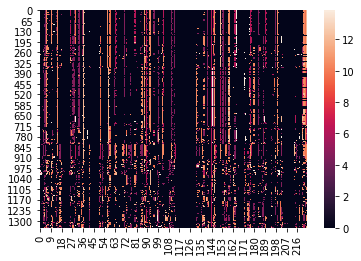

voxels example: gap matrix


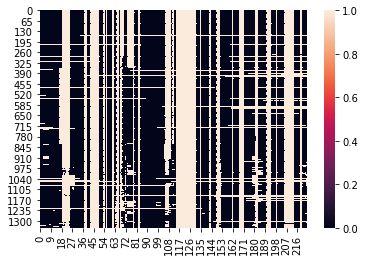

distmat for globins align (101M)


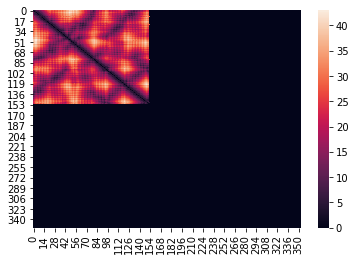

transformed voxels:


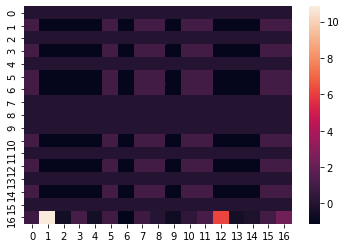

transformed distmats:


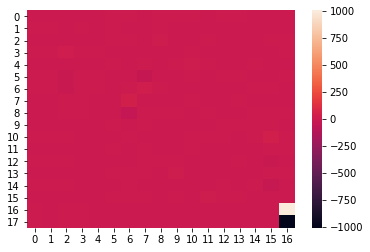

In [27]:
print("align")
print(aligns[0])
print("voxels example: pKa of side chain")
sns.heatmap(voxels[0,:,:,0])
plt.show()
print("voxels example: gap matrix")
sns.heatmap(voxels[0,:,:,12])
plt.show()
print("distmat for globins align (101M)")
sns.heatmap(distmats[0])
plt.show()

print("transformed voxels:")
sns.heatmap(transformed_voxels)
plt.show()
print("transformed distmats:")
sns.heatmap(transformed_distmats)
plt.show()